# Are COGS professors better than Math professors at UCSD? 

## Background
Based on the classes that I've taken with the departments, and the CAPE reviews that I've looked over, I had a theory that the professors in the Math department were inferior to the professors in the COGS department. However, I've never actually had any real way to prove it. This notebook explores some statistical tests of the hypothesis, "Are COGS professors better than Math professors based on CAPE Recommend Instructor rates?" 

Credit to Tyler Flar on GitHub for getting CAPES data in a .csv format: https://github.com/TylerFlar

## Data Wrangling

Imports:

In [32]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import seaborn as sns
sns.set()
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest, mannwhitneyu
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

Merge two dataframes

In [33]:
math = pd.read_csv("math-merged.csv")
cogs = pd.read_csv("cogs-merged.csv")

df = pd.concat([math, cogs], ignore_index=True).reset_index()
df



,index,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received
0,0,"Kedlaya, Kiran S.",\nMATH 100A - Abstract Algebra I (A)\n,FA22,43,\n12\n,\n75.0%\n,\n83.3%\n,\n8.83\n,\nB (3.17)\n,\nB (3.24)\n
1,1,"Greenfeld, Be'Eri",\nMATH 100A - Abstract Algebra I (B)\n,FA22,51,\n21\n,\n76.2%\n,\n75.0%\n,\n8.31\n,\nB+ (3.38)\n,\nB (3.14)\n
2,2,"Alberts, Brandon",\nMATH 100A - Abstract Algebra I (A)\n,FA21,57,\n27\n,\n84.6%\n,\n88.5%\n,\n9.65\n,\nB (3.00)\n,\nC+ (2.67)\n
3,3,"Kedlaya, Kiran S.",\nMATH 100A - Abstract Algebra I (B)\n,FA21,65,\n29\n,\n82.1%\n,\n92.9%\n,\n10.21\n,\nB (3.18)\n,\nC+ (2.68)\n
4,4,"Sorensen, Claus M",\nMATH 100A - Abstract Algebra I (A)\n,FA20,55,\n49\n,\n81.3%\n,\n78.7%\n,\n9.88\n,\nB (3.02)\n,\nB (3.21)\n
...,...,...,...,...,...,...,...,...,...,...,...
4209,4209,"Kutas, Marta",\nCOGS 91 - SCANS Presents (A)\n,FA07,15,\n14\n,\n100.0%\n,\n100.0%\n,\n0.50\n,\nN/A\n,\nN/A\n
4210,4210,Instructor,Course,Term,Enroll,Evals Made,Rcmnd Class,Rcmnd Instr,Study Hrs/wk,Avg Grade Expected,Avg Grade Received
4211,4211,"Schul, Rina S.F.",\nCOGS 92 - Resiliency/Face of Adversity (B)\n,FA12,24,\n10\n,\n80.0%\n,\n80.0%\n,\n1.30\n,\nA (4.00)\n,\nN/A\n
4212,4212,"Schul, Rina S.F.",\nCOGS 92 - Resiliency/Face of Adversity (A)\n,FA10,13,\n8\n,\n87.5%\n,\n87.5%\n,\n1.50\n,\nA (4.00)\n,\nN/A\n


Exclude rows with column info


In [34]:
dfMod = df[df["Instructor"] != "Instructor"]


Write function to strip "/n" characters

In [35]:
def stripN(string):
    string = str(string)
    string = string.strip()
    string = string.lower()
    if "%" in string:
        string = string.replace("%", "")
    if "\n" in string:
        string = string.replace("\n", "")
    return string

Apply function, remove "n/a" strings

In [36]:
dfMod['Course'] = dfMod['Course'].apply(stripN)
dfMod['Evals Made'] = dfMod['Evals Made'].apply(stripN)
dfMod["Rcmnd Class"] = dfMod["Rcmnd Class"].apply(stripN)
dfMod["Rcmnd Instr"] = dfMod["Rcmnd Instr"].apply(stripN)
dfMod["Study Hrs/wk"] = dfMod["Study Hrs/wk"].apply(stripN)
dfMod["Avg Grade Expected"] = dfMod["Avg Grade Expected"].apply(stripN)
dfMod["Avg Grade Received"] = dfMod["Avg Grade Received"].apply(stripN)

dfMod = dfMod.dropna()
dfMod = dfMod[dfMod["Avg Grade Expected"] != "n/a"]
dfMod = dfMod[dfMod["Avg Grade Received"] != "n/a"]





Define functions for determining department and removing non numeric characters

In [37]:
def course(string):
    if "math" in string:
        string = "math"
    elif "cogs" in string:
        string = "cogs"
    return string
def remove_non_numeric(string):
    # Define the string and the list
    string = str(string)
    list = ["a", "b", "c", "d", "f", "(", ")", "+", "-", "/n", "\n", "n/", '']
    for e in list:
        if e in string:
            string = string.replace(e, "")
    string = float(string)
    return string



Change datatypes and apply functions

In [38]:
dfMod['Rcmnd Instr'] = dfMod['Rcmnd Instr'].astype(float)
dfMod['Rcmnd Class'] = dfMod['Rcmnd Class'].astype(float)
dfMod['Study Hrs/wk'] = dfMod['Study Hrs/wk'].astype(float)
dfMod['Enroll'] = dfMod['Enroll'].astype(int)
dfMod['Evals Made'] = dfMod['Evals Made'].astype(int)

dfMod["Department"] = dfMod["Course"].apply(course)
dfMod["Avg Grade Received"] = dfMod["Avg Grade Received"].apply(remove_non_numeric)
dfMod["Avg Grade Expected"] = dfMod["Avg Grade Expected"].apply(remove_non_numeric)

#dfMod["Avg Grade Received"] = pd.to_numeric(dfMod["Avg Grade Received"])





## Run Statistical Tests

### Test 1: Mann Whitney U Test

Plot distribution of COGS professor ratings vs math professor ratings

<Axes: xlabel='Rcmnd Instr', ylabel='Count'>

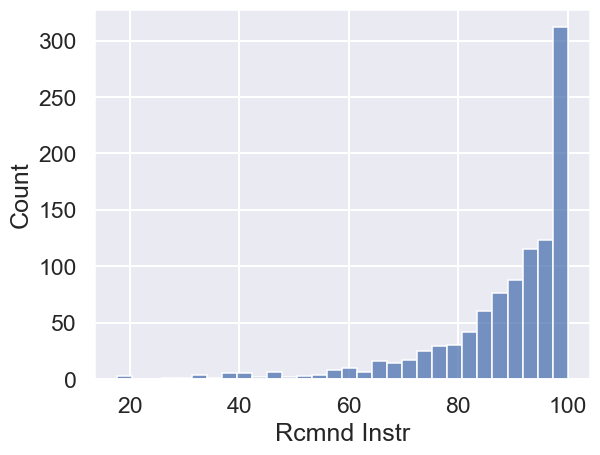

In [39]:
sns.histplot(data=dfMod[dfMod.get("Department").str.contains("cogs")], x="Rcmnd Instr")

<Axes: xlabel='Rcmnd Instr', ylabel='Count'>

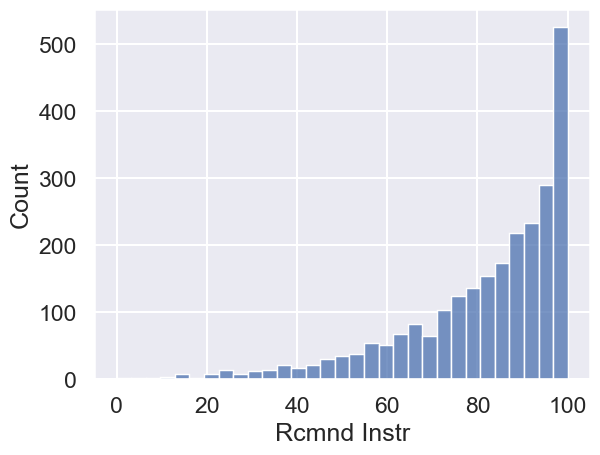

In [40]:
sns.histplot(data=dfMod[dfMod.get("Department").str.contains("math")], x="Rcmnd Instr")

Run Mann Whitney U test on data.

H0: There is no difference between the distributions of the data

H1: There IS a difference between the distributions of the data

In [41]:
cogs_series = dfMod[dfMod.get("Department").str.contains("cogs")].get("Rcmnd Instr")
math_series = dfMod[dfMod.get("Department").str.contains("math")].get("Rcmnd Instr")
math_mean = math_series.mean()
cogs_mean = cogs_series.mean()
U_val, p_val = mannwhitneyu(cogs_series, math_series)

In [42]:
p_val

1.4188994528408778e-28

In [43]:
cogs_mean

88.68343253968253

In [44]:
math_mean

81.88399840383082

### Test 1 Results: 

We have evidence that there IS a difference in the distributions of math and COGS professor ratings. Therefore we can conclude that the different means is not due to chance.

## Test 2a: OLS

We then run an OLS regression test to see how much the department of the class is indicative of the professor rating. 

In [45]:
outcome_1, predictors_1 = patsy.dmatrices('Q("Rcmnd Instr") ~ Department', dfMod)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("Rcmnd Instr")   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     117.0
Date:                Sat, 25 Nov 2023   Prob (F-statistic):           7.59e-27
Time:                        12:29:22   Log-Likelihood:                -14911.
No. Observations:                3514   AIC:                         2.983e+04
Df Residuals:                    3512   BIC:                         2.984e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             88.6834      0

With these results, we don't have evidence to conclude that the department is strictly indicative of the instructor rating. We can see that statistics like the R-squared value are super low, indicating that a tiny percentage of the data can be represented using the OLS line. 

What about if we incorporate more variables? 

## Test 2b: Multi variable OLS:

In [46]:
outcome_2, predictors_2 = patsy.dmatrices('Q("Rcmnd Instr") ~ Department + Q("Enroll")+ Q("Evals Made")+ Q("Rcmnd Class")+ Q("Study Hrs/wk")+ Q("Avg Grade Expected") + Q("Avg Grade Received")', dfMod)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("Rcmnd Instr")   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     448.9
Date:                Sat, 25 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:29:22   Log-Likelihood:                -13844.
No. Observations:                3514   AIC:                         2.770e+04
Df Residuals:                    3506   BIC:                         2.775e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

With these results, we can somewhat conclude that the department of a professor is indicative of their ratings. The regression line indicates that being a part of the math department lowers their rating by 4.8 points! This result is also statistically significant. However, our R-squared value is only 0.473. Only about 49.3% of the variation can be explained by the dependent variables. 

## Conclusion
We have some evidence to conclude that math professors are worse than COGS professors. The Mann-Whitney U test indicates that the mean COGS professor rating being higher and the math professor rating being lower is not due to chance and that they come from two different distributions. When running an OLS analysis, we also have evidence that being a part of the math department correlates with a lower professor rating. However, the OLS results have a low R-squared value, which indicates that only about half of the variability in the data can be accounted for using the regression line. While our tests do point to math professors being worse than COGS professors, we would need to account for other variables, like difficulty of the course, ability to explain things, etc. 